In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
#@save
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [3]:
# Class predictor
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)


In [4]:
# Bounding box predictor
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [5]:
# apply block for tensor x
def forward(x, block):
    return block(x)

In [6]:
# Test
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
print(Y1.shape, Y2.shape)

torch.Size([2, 55, 20, 20]) torch.Size([2, 33, 10, 10])


In [7]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)


In [8]:
# Concatnate predictors
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [9]:
print(concat_preds([Y1, Y2]).shape)

torch.Size([2, 25300])


In [10]:
# Down sampling block
def down_sample_blk(in_channels, out_channels):
    blk = []
    # 2 convolutional layer (3x3) , padding = 1
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    # pooling layer with stride = 2
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [11]:
print(forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape)

torch.Size([2, 10, 10, 10])


In [12]:
# Base network
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

In [13]:
print(forward(torch.zeros((2, 3, 256, 256)), base_net()).shape)

torch.Size([2, 64, 32, 32])


In [14]:
# Block info: 0 : base net work, 1 : downsampling block(64 -> 128), 2- 3: downsampling block(128 -> 128), 4: maxPooling 
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [15]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [16]:
# Initialize size, ratio and num anchor
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [17]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [18]:
# Define net
net = TinySSD(num_classes=1)


In [23]:
# Read dataset
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [24]:
# Initialize parameter and optimization algorithm
net = TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

In [25]:
#  Defining Loss and Evaluation Functions
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [26]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

In [27]:
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

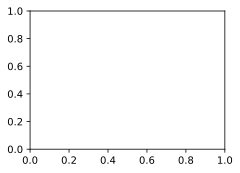

In [28]:
# Training model
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to('cuda')

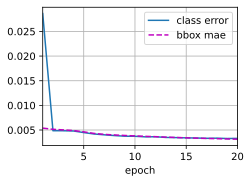

In [29]:
# Training
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to('cuda'), target.to('cuda')
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))

In [30]:
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
        'cuda')

class err 3.31e-03, bbox mae 3.14e-03
5112.7 examples/sec on cuda


In [31]:
#  # Save the model
torch.save(net.state_dict(), 'SSD_Model.pth')

In [19]:
# Load Model
# Assuming 'net' is your model and 'path_to_weights' is the path to your weights file
path_to_weights = 'E:\Project\SamSungR&D\Computer Vision\SSD\SSD_Model.pth'

# Load the state dictionary from the file
state_dict = torch.load(path_to_weights)

# Load the state dictionary into your model
net.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
net.to('cuda')

TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

In [21]:
# Predict
'''Read image''' 
X = torchvision.io.read_image('E:\\Project\\SamSungR&D\\Computer Vision\\img\\test2.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

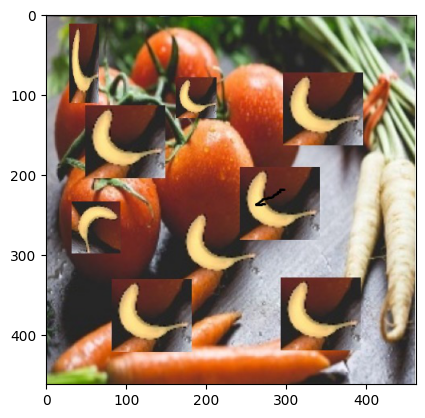

In [22]:
# Show Image
plt.imshow(img)
plt.show()

In [23]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to('cuda'))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

In [24]:
output = predict(X)

In [25]:
print(output)

tensor([[ 0.0000,  0.9913,  0.6115,  0.1424,  0.8279,  0.3449],
        [ 0.0000,  0.9910,  0.0716,  0.2296,  0.2878,  0.4371],
        [ 0.0000,  0.9907,  0.6046,  0.7064,  0.8190,  0.9010],
        [ 0.0000,  0.9903,  0.3346,  0.5231,  0.5426,  0.7220],
        [ 0.0000,  0.9898,  0.1450,  0.7032,  0.3639,  0.9179],
        [ 0.0000,  0.9835,  0.4786,  0.3935,  0.6952,  0.6033],
        [ 0.0000,  0.9609,  0.2883,  0.1126,  0.5073,  0.3051],
        [ 0.0000,  0.9135,  0.0394,  0.4758,  0.2482,  0.6929],
        [ 0.0000,  0.8391, -0.0061,  0.0375,  0.2136,  0.2330],
        [ 0.0000,  0.8330,  0.0303,  0.1052,  0.2295,  0.3091],
        [ 0.0000,  0.7687,  0.2086,  0.7996,  0.4028,  1.0006],
        [ 0.0000,  0.7530,  0.1388,  0.3234,  0.3465,  0.5379],
        [ 0.0000,  0.6600,  0.6656,  0.7964,  0.8775,  1.0161],
        [ 0.0000,  0.6066,  0.3414,  0.1837,  0.5347,  0.3792],
        [ 0.0000,  0.5060,  0.0462,  0.4071,  0.2464,  0.6083],
        [ 0.0000,  0.5051,  0.3567,  0.5

In [26]:
# Display
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

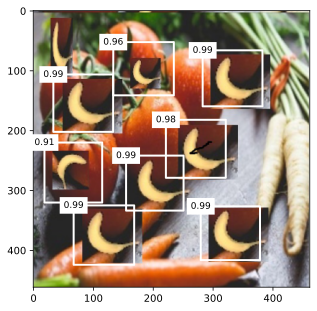

In [27]:
display(img, output.cpu(), threshold=0.9)